In [1]:
# libraries
from __future__ import print_function
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

import BayesianLayers
from compression import compute_compression_rate, compute_reduced_weights
from utils import visualize_pixel_importance, generate_gif, visualise_weights

import itertools
from scipy import linalg
import matplotlib as mpl
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate
import random as rand
import pandas as pd
from sklearn import mixture
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
sns.set()
rand.seed(2020)

In [106]:
N = 60000.  # number of data points in the training set
n_of_network_samples = 100
n_of_gaussians = 5
train_frac = 0.8
percent_of_measurements = 0.6

## Fitting Solar and Normal data separately with Gaussian Mixture
#### Initially, a GMM with 3 components will be fitted, like in the original paper. Later, other pdfs will be tested.

In [3]:
base_path = "/electricity_data/"

train_data_path = base_path + "2011-2012 Solar home electricity data v2.csv"
test_data_path = base_path + "2012-2013 Solar home electricity data v2.csv"

In [4]:
train_data = pd.read_csv(train_data_path, skiprows=1)
test_data = pd.read_csv(test_data_path, skiprows=1)

### GC = General Consumption for electricity supplied all the time (primary tariff, either inclining block or time of use rates), excluding solar generation and controlled load supply 
### CL = Controlled Load Consumption (Off peak 1 or 2 tariffs)
### GG = Gross Generation for electricity generated by the solar system with a gross metering configuration, measured separately to household loads

In [5]:
train_data.head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
0,1,3.78,2076,CL,1/07/2011,1.250,1.250,1.250,0.625,0.219,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.063,NaN
1,1,3.78,2076,GC,1/07/2011,1.077,0.669,0.674,0.615,0.321,...,0.276,0.241,0.168,0.234,0.164,0.639,0.118,0.219,0.162,NaN
2,1,3.78,2076,GG,1/07/2011,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
3,1,3.78,2076,CL,2/07/2011,1.238,1.244,1.194,0.000,0.888,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075,NaN
4,1,3.78,2076,GC,2/07/2011,0.476,0.130,0.044,0.094,0.032,...,0.234,0.306,0.183,0.240,0.170,0.506,0.224,0.088,0.084,NaN


In [6]:
def extract_consumption_values(data_df):
    
    selected_columns = [col for col in data_df.columns if ":" in col]

    data_df_general = data_df[data_df['Consumption Category'] == 'GC']
    
    data_df_solar = data_df[data_df['Consumption Category'] == 'GG']
    
    return data_df_general[selected_columns], data_df_solar[selected_columns]


In [7]:
train_data_general, train_data_solar = extract_consumption_values(train_data)
test_data_general, test_data_solar = extract_consumption_values(test_data)

In [8]:
train_values = np.reshape(train_data_general.values, (train_data_general.shape[0]*train_data_general.shape[1],1))
test_values = np.reshape(test_data_general.values, (test_data_general.shape[0]*test_data_general.shape[1],1))

In [9]:
# # Fit a Dirichlet process Gaussian mixture using five components
# dpgmm = mixture.BayesianGaussianMixture(n_components=n_of_gaussians,
#                                         covariance_type='full').fit(train_values)
# # plot_results(train_values, dpgmm.predict(train_values), dpgmm.means_, dpgmm.covariances_, 1,
# #              'Bayesian Gaussian Mixture with a Dirichlet process prior (train)')
# plt.scatter(dpgmm.predict(test_values),test_values)

In [10]:
# # plot_results(test_values, dpgmm.predict(test_values), dpgmm.means_, dpgmm.covariances_, 1,
# #              'Bayesian Gaussian Mixture with a Dirichlet process prior (test)')
# plt.scatter(gmm.predict(test_values),test_values)

In [11]:
#Code based on: https://stackoverflow.com/questions/39920862/model-selection-for-gaussianmixture-by-using-gridsearch 
bic = np.zeros(9)
n = np.arange(1,10)
models = []
#loop through each number of Gaussians and compute the BIC, and save the model
for i,j in enumerate(n):
    #create mixture model with j components
    gmm = mixture.GaussianMixture(n_components=j)
    #fit it to the data
    gmm.fit(train_values)
    #compute the BIC for this model
    bic[i] = gmm.bic(test_values)
    #add the best-fit model with j components to the list of models
    models.append(gmm)
    
plt.plot(n,bic)

#### n_of_components=5 was initially chosen

In [9]:
gmm = mixture.GaussianMixture(n_components=n_of_gaussians)
#fit it to the data
gmm.fit(train_values)

GaussianMixture(n_components=5)

#### Solar consumption data was either 0 or NaN. We will only fit GMM on the General Consumption values.

## Generating samples from Network

In [103]:
# Define Network
# net = pn.case14()
net = pn.case57()

In [104]:
net.bus

,in_service,max_vm_pu,min_vm_pu,name,type,vn_kv,zone
0,True,1.06,0.94,1,b,115.0,1
1,True,1.06,0.94,2,b,115.0,1
10,True,1.06,0.94,11,b,115.0,1
11,True,1.06,0.94,12,b,115.0,1
12,True,1.06,0.94,13,b,115.0,1
13,True,1.06,0.94,14,b,115.0,1
14,True,1.06,0.94,15,b,115.0,1
15,True,1.06,0.94,16,b,115.0,1
16,True,1.06,0.94,17,b,115.0,1
17,True,1.06,0.94,18,b,500.0,1


In [107]:
injection_values, network_state_samples, measurement_vector = np.zeros((n_of_network_samples,net.bus.shape[0])),\
np.zeros((n_of_network_samples,net.bus.shape[0])), np.zeros((n_of_network_samples,int(net.bus.shape[0]*percent_of_measurements)))

measurement_indices = rand.sample(range(net.bus.shape[0]),int(net.bus.shape[0]*percent_of_measurements))

print(range(net.bus.shape[0]))

print(measurement_indices)

for i in range(n_of_network_samples):

    net = pn.case57()
    
    injection_values_per_iter = -2e-3*np.squeeze(gmm.sample(n_samples=net.bus.shape[0])[0])
    
    injection_values[i,:] = injection_values_per_iter
    
    k = 0
    
    # Need to figure out to to get value parameter for line current measurements, since the data only show max voltage.
    
    # For now, working with voltage measurements
    
    measurements = np.zeros((net.bus.shape[0],))
    
    for j in range(net.bus.shape[0]):
        
        ref_bus_voltage = net.bus.vn_kv[j]
        
        measurement_value = ref_bus_voltage + rand.normalvariate(0,0.1*ref_bus_voltage)
            
        pp.create_measurement(net=net, meas_type='v', element_type='bus', value=ref_bus_voltage, std_dev=0.1*ref_bus_voltage, element=j, side=None, check_existing=True, index=None, name=None)
 
        pp.create_measurement(net=net, meas_type='p', element_type='bus', value=injection_values_per_iter[j], std_dev=0.1*ref_bus_voltage, element=j, side=None, check_existing=True, index=None, name=None)

        pp.create_sgen(net=net, bus=j, p_mw=injection_values_per_iter[j])
        
        
    pp.runpp(net)
    
    success = pp.estimation.estimate(net, init="flat")
    V, delta = net.res_bus_est.vm_pu, net.res_bus_est.va_degree

    #print("Z: ", net.res_bus.vm_pu.values)
    
    network_state_samples[i,:] = net.res_bus.vm_pu.values
    
    measurement_vector[i,:] = measurements[measurement_indices] #net.res_bus_est.vm_pu.values[measurement_indices]

range(0, 57)
[38, 14, 48, 10, 19, 35, 30, 56, 52, 15, 44, 2, 43, 27, 28, 0, 6, 11, 34, 53, 22, 13, 21, 45, 41, 18, 4, 50, 37, 47, 7, 5, 49, 8]


## Fitting NN Model

In [108]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2*measurement_vector.shape[1],input_dim=measurement_vector.shape[1]),
    tf.keras.layers.Dense(measurement_vector.shape[1], input_dim=2*measurement_vector.shape[1]),
    tf.keras.layers.Dense(network_state_samples.shape[1], input_dim=measurement_vector.shape[1]),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=tf.keras.optimizers.SGD(lr=0.2),
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    injection_values[:int(measurement_vector.shape[0]*train_frac)], # input
    network_state_samples[:int(measurement_vector.shape[0]*train_frac)], # output
    batch_size=int(measurement_vector.shape[0]*train_frac),
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=50,
    validation_data=(injection_values[int(measurement_vector.shape[0]*train_frac):], network_state_samples[int(measurement_vector.shape[0]*train_frac):]),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))


Training ... With default parameters, this takes less than 10 seconds.
Average test loss:  0.22885611320496538


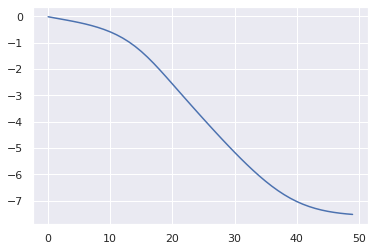

In [109]:
plt.plot(np.log(training_history.history['loss']))

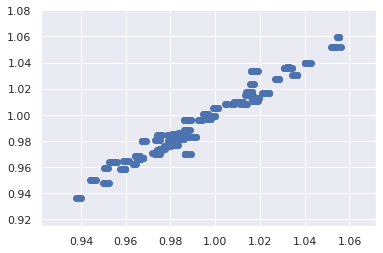

In [110]:
plt.scatter(model.predict(injection_values[-10:]),network_state_samples[-10:])

In [113]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
This portion of the code is based in the 'example.py' file of: 
Karen Ullrich, Christos Louizos, Oct 2017
"""

def main(injection_values, measurement_vector, train_frac, network_state_samples, FLAGS):
    # import data
    kwargs = {'num_workers': 1, 'pin_memory': True} if FLAGS.cuda else {}
    
    train_tensor_x = torch.Tensor(measurement_vector[:int(measurement_vector.shape[0]*train_frac)]).unsqueeze(1) # transform to torch tensor
    train_tensor_y = torch.Tensor(network_state_samples[:int(measurement_vector.shape[0]*train_frac)])#.unsqueeze(1)

    train_dataset = torch.utils.data.TensorDataset(train_tensor_x,train_tensor_y) # create your datset
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=FLAGS.batchsize, shuffle=True, **kwargs) # create your dataloader

    print(train_tensor_x.shape,train_tensor_y.shape)
    
    
    test_tensor_x = torch.Tensor(measurement_vector[int(measurement_vector.shape[0]*train_frac):]).unsqueeze(1) # transform to torch tensor
    test_tensor_y = torch.Tensor(network_state_samples[int(measurement_vector.shape[0]*train_frac):])#.unsqueeze(1)

    test_dataset = torch.utils.data.TensorDataset(test_tensor_x,test_tensor_y) # create your datset
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=FLAGS.batchsize, shuffle=True, **kwargs) # create your dataloader

    # for later analysis we take some sample digits
    mask = 255. * (np.ones((1, 1, injection_values[0].shape[0])))

    # build a simple MLP
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            # activation
            self.relu = nn.ReLU()
            # layers
            self.fc1 = BayesianLayers.LinearGroupNJ(measurement_vector.shape[1], 10*measurement_vector.shape[1], clip_var=0.04, cuda=FLAGS.cuda)
            self.fc2 = BayesianLayers.LinearGroupNJ(10*measurement_vector.shape[1],5*measurement_vector.shape[1], cuda=FLAGS.cuda)
            self.fc3 = BayesianLayers.LinearGroupNJ(5*measurement_vector.shape[1],network_state_samples.shape[1], cuda=FLAGS.cuda)
            # layers including kl_divergence
            self.kl_list = [self.fc1, self.fc2, self.fc3]

        def forward(self, x):
            x = x.view(-1, measurement_vector.shape[1])#28 * 28)
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            return self.fc3(x)

        def get_masks(self,thresholds):
            weight_masks = []
            mask = None
            for i, (layer, threshold) in enumerate(zip(self.kl_list, thresholds)):
                # compute dropout mask
                if mask is None:
                    log_alpha = layer.get_log_dropout_rates().cpu().data.numpy()
                    mask = log_alpha < threshold
                else:
                    mask = np.copy(next_mask)
                try:
                    log_alpha = layers[i + 1].get_log_dropout_rates().cpu().data.numpy()
                    next_mask = log_alpha < thresholds[i + 1]
                except:
                    # must be the last mask
                    next_mask = np.ones(network_state_samples.shape[1])

                weight_mask = np.expand_dims(mask, axis=0) * np.expand_dims(next_mask, axis=1)
                weight_masks.append(weight_mask.astype(np.float))
            return weight_masks

        def kl_divergence(self):
            KLD = 0
            for layer in self.kl_list:
                KLD += layer.kl_divergence()
            return KLD

    # init model
    model = Net()
    if FLAGS.cuda:
        model.cuda()

    # init optimizer
    optimizer = optim.Adam(model.parameters())

    # we optimize the variational lower bound scaled by the number of data
    # points (so we can keep our intuitions about hyper-params such as the learning rate)
    discrimination_loss = nn.functional.mse_loss #cross_entropy

    def objective(output, target, kl_divergence):
        discrimination_error = discrimination_loss(output, target)
        variational_bound = discrimination_error + kl_divergence / N
        if FLAGS.cuda:
            variational_bound = variational_bound.cuda()
        return variational_bound

    def train(epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if FLAGS.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            #print("output: ", output.shape,"target: ", target.squeeze().shape)
            loss = objective(output, target, model.kl_divergence())
            loss.backward()
            optimizer.step()
            # clip the variances after each step
            for layer in model.kl_list:
                layer.clip_variances()
        print('Epoch: {} \tTrain loss: {:.8f} \t'.format(
            epoch, loss.data))

    def test():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if FLAGS.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            test_loss += discrimination_loss(output, target, size_average=False).data
            pred = output.data#.max(1, keepdim=True)[1]
            #print("pred: ", pred.shape)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        test_loss /= len(test_loader.dataset)
        print('Test loss: {:.8f}, Accuracy: {}/{} ({:.8f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    # train the model and save some visualisations on the way
    for epoch in range(1, FLAGS.epochs + 1):
        train(epoch)
        test()
        # visualizations
        weight_mus = [model.fc1.weight_mu, model.fc2.weight_mu]
        log_alphas = [model.fc1.get_log_dropout_rates(), model.fc2.get_log_dropout_rates(),
                      model.fc3.get_log_dropout_rates()]
        visualise_weights(weight_mus, log_alphas, epoch=epoch)
        log_alpha = model.fc1.get_log_dropout_rates().cpu().data.numpy()
        #visualize_pixel_importance(images, log_alpha=log_alpha, epoch=str(epoch))

#     generate_gif(save='pixel', epochs=FLAGS.epochs)
#     generate_gif(save='weight0_e', epochs=FLAGS.epochs)
#     generate_gif(save='weight1_e', epochs=FLAGS.epochs)

    # compute compression rate and new model accuracy
    layers = [model.fc1, model.fc2, model.fc3]
    thresholds = FLAGS.thresholds
    #print(model.get_masks(thresholds))
    compute_compression_rate(layers, model.get_masks(thresholds))

    print("Test error after with reduced bit precision:")

    weights = compute_reduced_weights(layers, model.get_masks(thresholds))
    for layer, weight in zip(layers, weights):
        if FLAGS.cuda:
            layer.post_weight_mu.data = torch.Tensor(weight).cuda()
        else:
            layer.post_weight_mu.data = torch.Tensor(weight)
    for layer in layers: layer.deterministic = True
    test()


if __name__ == '__main__':

    class FLAGS:
        epochs=50
        batchsize=100
        thresholds=[-2.8, -3., -5.]
        
    FLAGS.cuda = torch.cuda.is_available()  # check if we can put the net on the GPU

    main(injection_values, measurement_vector, train_frac, network_state_samples, FLAGS)

torch.Size([80, 1, 34]) torch.Size([80, 57])
Epoch: 1 	Train loss: 6.34267664 	
Test loss: 55.91337967, Accuracy: 0/20 (0.00000000%)



/home/rafael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 2 	Train loss: 6.33382320 	
Test loss: 55.52239990, Accuracy: 0/20 (0.00000000%)

Epoch: 3 	Train loss: 6.32401276 	
Test loss: 55.04512405, Accuracy: 0/20 (0.00000000%)

Epoch: 4 	Train loss: 6.31157303 	
Test loss: 54.46619797, Accuracy: 0/20 (0.00000000%)

Epoch: 5 	Train loss: 6.29954720 	
Test loss: 53.77098465, Accuracy: 0/20 (0.00000000%)

Epoch: 6 	Train loss: 6.28539276 	
Test loss: 52.94573212, Accuracy: 0/20 (0.00000000%)

Epoch: 7 	Train loss: 6.26843500 	
Test loss: 51.97079468, Accuracy: 0/20 (0.00000000%)

Epoch: 8 	Train loss: 6.24978304 	
Test loss: 50.82783508, Accuracy: 0/20 (0.00000000%)

Epoch: 9 	Train loss: 6.22745657 	
Test loss: 49.50058365, Accuracy: 0/20 (0.00000000%)

Epoch: 10 	Train loss: 6.20271158 	
Test loss: 47.96605301, Accuracy: 0/20 (0.00000000%)

Epoch: 11 	Train loss: 6.17297506 	
Test loss: 46.20746231, Accuracy: 0/20 (0.00000000%)

Epoch: 12 	Train loss: 6.14110279 	
Test loss: 44.20560455, Accuracy: 0/20 (0.00000000%)

Epoch: 13 	Train l